Checking the rater agreement (pct viewing time) for all frames

In [109]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.misc
from tabulate import tabulate
from sklearn.metrics import cohen_kappa_score
import krippendorff

Load the ratings of the algorithm and the raters

In [110]:
# Load data from algorithmic tracking
raterFiles = glob.glob("data/P*.txt")
df_algoFiles = (pd.read_csv(f, header = None) for f in raterFiles)
df_algo   = pd.concat(df_algoFiles, ignore_index=True, axis = 0)

# Load data from manual ratings
raterFiles = glob.glob("data/data_Rater*.csv")
df_raterFiles = (pd.read_csv(f, header = 0) for f in raterFiles)
df_rater   = pd.concat(df_raterFiles, ignore_index=True)

Prepare the data to get it into long format

In [111]:
# Only take the last judgement of each rater
df_rater.drop_duplicates(subset=['Rater', 'Frame', 'Trial'], keep='last', inplace = True)

# Rename columns
df_algo.columns = ["Trial", "Label", "1", "2", "3", "4", "5", "6", "VisiblePoints", "7", "8" ]

# Add frame number column
df_algo["Frame"] = df_algo.groupby(['Trial']).cumcount()

# Add column for rater
df_algo['Rater'] = 'Algorithm'

# Set datatypes
df_algo["Trial"] = df_algo["Trial"].astype("string")
df_algo["Frame"] = df_algo["Frame"].astype("string")
df_algo["Label"] = df_algo["Label"].astype("string")
df_rater["Frame"] = df_rater["Frame"].astype("string")
df_rater["Trial"] = df_rater["Trial"].astype("string")
df_rater["Label"] = df_rater["Label"].astype("string")

# Rename the labels to match the AOI from the algorithmic approach
df_algo['Label'] = df_algo['Label'].str.replace("Nose","Head")
df_algo['Label'] = df_algo['Label'].str.replace("Neck","Chest")
df_algo['Label'] = df_algo['Label'].str.replace("LElbow","Left arm")
df_algo['Label'] = df_algo['Label'].str.replace("RElbow","Right arm")
df_algo['Label'] = df_algo['Label'].str.replace("RKnee","Right leg")
df_algo['Label'] = df_algo['Label'].str.replace("LKnee","Left leg")
df_algo['Label'] = df_algo['Label'].str.replace("MidHip","Pelvis")

# Check the unique values
# df_algo['Label'].unique()

Merge the data into Long format

In [112]:
# Merge data frames
df = pd.concat([df_algo, df_rater], join='outer', keys=['Trial', 'Frame', 'Rater', 'Label']).reset_index(drop=True)

# only keep rows where all ratings are available
def filterRows(group):
    if group.shape[0] > 1:
        return group

df = df.groupby(['Trial', 'Frame']).apply(filterRows).reset_index(drop=True)

df.ffill(inplace=True)
df = df[['Trial', 'Label', 'VisiblePoints', 'Frame', 'Rater']]

df.drop(columns=['VisiblePoints'], inplace=True)
df.to_csv("results/DataLong.csv", index=False)

What happens when gaze is on "Other". For the human raters, take the mode (most chosen answer)


In [113]:
def mode_of_frame(group):
    group['Mode'] = group.Label.mode()[0]
    group['isAnyOther'] = (group.Label == "Other").any()
    group['Algorithm_Label'] = group.loc[group.Rater == "Algorithm", 'Label']
    return group

df = df.groupby(['Trial', 'Frame']).apply(mode_of_frame)

Plot what happens when gaze is on "Other"

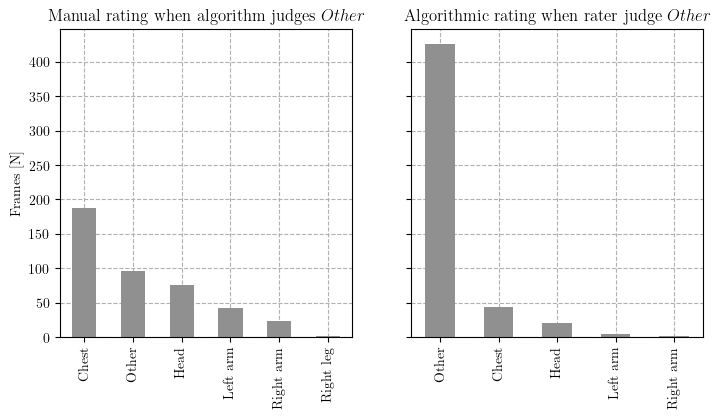

In [114]:
# Other plot

%matplotlib inline
mpl.style.use('default')

# The data
pct_algorithm = df.loc[(df.Rater == "Algorithm") & (df.Label == "Other"), 'Mode'].value_counts() 
pct_rater1 = df.loc[df.isAnyOther == 1, 'Algorithm_Label'].value_counts()

# Plot settings
# Requires probably on linux: sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
mpl.rcParams.update(
    {
        'font.family': 'serif',
        'text.usetex': True,
    }
)

# Figure settings for export
pts_document_with = 600. # How wide is the page
pts_per_inch = 1. / 72.27
figure_width = pts_document_with * pts_per_inch

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (figure_width,4), sharey = True)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)

pct_algorithm.plot(kind = 'bar', ax = axes[0], color = '#909090')
pct_rater1.plot(kind = 'bar', ax = axes[1], color = '#909090')

axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')

# fig.suptitle("AOI classification when subsetting on $Other$")
axes[0].set_ylabel("Frames [N]")
axes[0].set_title("Manual rating when algorithm judges $Other$")
axes[1].set_title("Algorithmic rating when rater judge $Other$")

# Save
plt.savefig("plots/RaterOtherSubset.svg", bbox_inches='tight')

Calculate the agreement betweeen each rater and the algorithm

In [115]:
# Create rating agreements between raters and algorithm, and among raters. Need data in wide format for this
df = df.pivot(index=['Trial', 'Frame'], columns='Rater', values='Label')

# Columns with comparison values
df['Rater1_Algorithm'] = df.Rater1 == df.Algorithm
df['Rater2_Algorithm'] = df.Rater2 == df.Algorithm
df['Rater3_Algorithm'] = df.Rater3 == df.Algorithm
df['Rater1_Rater2'] = df.Rater1 == df.Rater2
df['Rater1_Rater3'] = df.Rater1 == df.Rater3
df['Rater2_Rater3'] = df.Rater2 == df.Rater3
df['ManualRaters'] = (
    (df.Rater1 == df.Rater2) &
    (df.Rater1 == df.Rater3) &
    (df.Rater2 == df.Rater3))

# Drop Na's because they can't be converted to int
df.dropna(inplace=True)

# Calculate the rating agreement
rater1_algorithm_pct = ((df.Rater1_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater2_algorithm_pct = ((df.Rater2_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater3_algorithm_pct = ((df.Rater3_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater1_rater2_pct = ((df.Rater1_Rater2.astype(int).sum() / df.shape[0]) * 100)
rater1_rater3_pct = ((df.Rater1_Rater3.astype(int).sum() / df.shape[0]) * 100)
rater2_rater3_pct = ((df.Rater2_Rater3.astype(int).sum() / df.shape[0]) * 100)
rater_all_pct = ((df.ManualRaters.astype(int).sum() / df.shape[0]) * 100)

# Back to long format
df = df.stack().rename('Label').reset_index(['Frame', 'Trial', 'Rater'])

Inter rater reliability

In [116]:
# Create an index variable for the labels [0 .. n]
df['Label_ID'], _ = pd.factorize(df.Label)

algorithm = df.loc[df.Rater == "Algorithm", 'Label_ID']
rater1 = df.loc[df.Rater == "Rater1", 'Label_ID']
rater2 = df.loc[df.Rater == "Rater2", 'Label_ID']
rater3 = df.loc[df.Rater == "Rater3", 'Label_ID']

rater1_rater2_kappa = cohen_kappa_score(rater1, rater2)
rater1_rater3_kappa = cohen_kappa_score(rater1, rater3)
rater2_rater3_kappa = cohen_kappa_score(rater2, rater3)
rater1_algorithm_kappa = cohen_kappa_score(algorithm, rater1)
rater2_algorithm_kappa = cohen_kappa_score(algorithm, rater2)
rater3_algorithm_kappa = cohen_kappa_score(algorithm, rater3)


Inter rater reliability among manual raters and among all raters

In [117]:
# Initiate lists and rater tags
manualList = []
manualRaters = ['Rater1', 'Rater2', 'Rater3']

def append_to_list(group, compareRaters, outList):
    subset = group[group.Rater.isin(compareRaters)] 
    outList.append(subset.Label_ID.to_list())

# Run for both groups
df.groupby(['Trial', 'Frame']).apply(append_to_list, manualRaters, manualList)

# Run Krippendorffs kappa
kappa_manualRaters = krippendorff.alpha(np.array(manualList).T)

Visualize and save the results and the data

In [118]:
# Create table
table = [
    ["Comparison all AOI", "Percent agreement [%]", "Reliability [Cohens Kappa]"],
    ["Rater 1 vs. Algorithm", rater1_algorithm_pct, rater1_algorithm_kappa],
    ["Rater 2 vs. Algorithm", rater2_algorithm_pct, rater2_algorithm_kappa],
    ["Rater 3 vs. Algorithm", rater3_algorithm_pct, rater3_algorithm_kappa],
    ["Rater 1 vs. Rater 2", rater1_rater2_pct, rater1_rater2_kappa],
    ["Rater 1 vs. Rater 3", rater1_rater3_pct, rater1_rater3_kappa],
    ["Rater 2 vs. Rater 3", rater2_rater3_pct, rater2_rater3_kappa],
    ["Among manual raters", rater_all_pct , kappa_manualRaters],
]

tabulate_table = tabulate(
    table,
    headers="firstrow",
    floatfmt=".2f",
    tablefmt="github")

print(tabulate_table)

# Save table
with open('results/Reliability_AllAOI.txt', 'w') as f:
    f.write(tabulate_table)

# Save data
df.to_csv("results/data_all.csv")

| Comparison all AOI    |   Percent agreement [%] |   Reliability [Cohens Kappa] |
|-----------------------|-------------------------|------------------------------|
| Rater 1 vs. Algorithm |                   59.76 |                         0.39 |
| Rater 2 vs. Algorithm |                   47.73 |                         0.27 |
| Rater 3 vs. Algorithm |                   54.12 |                         0.33 |
| Rater 1 vs. Rater 2   |                   77.86 |                         0.67 |
| Rater 1 vs. Rater 3   |                   80.56 |                         0.70 |
| Rater 2 vs. Rater 3   |                   75.34 |                         0.64 |
| Among manual raters   |                   68.35 |                         0.63 |


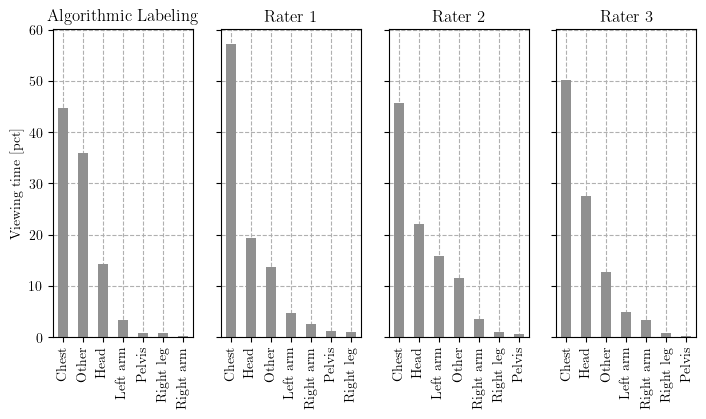

In [119]:
%matplotlib inline
mpl.style.use('default')

# The data
pct_algorithm = (df.loc[df.Rater == "Algorithm", 'Label'].value_counts() / df.loc[df.Rater == "Algorithm"].shape[0]) * 100
pct_rater1 = (df.loc[df.Rater == "Rater1", 'Label'].value_counts() / df.loc[df.Rater == "Rater1"].shape[0]) * 100
pct_rater2 = (df.loc[df.Rater == "Rater2", 'Label'].value_counts() / df.loc[df.Rater == "Rater2"].shape[0]) * 100
pct_rater3 = (df.loc[df.Rater == "Rater3", 'Label'].value_counts() / df.loc[df.Rater == "Rater3"].shape[0]) * 100

# Plot settings
# Requires probably on linux: sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
mpl.rcParams.update(
    {
        'font.family': 'serif',
        'text.usetex': True,
    }
)

# Figure settings for export
pts_document_with = 600. # How wide is the page
pts_per_inch = 1. / 72.27
figure_width = pts_document_with * pts_per_inch

# Plot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (figure_width,4), sharey = True)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)
axes[2].set_axisbelow(True)
axes[3].set_axisbelow(True)

pct_algorithm.plot(kind = 'bar', ax = axes[0], color = '#909090')
pct_rater1.plot(kind = 'bar', ax = axes[1], color = '#909090')
pct_rater2.plot(kind = 'bar', ax = axes[2], color = '#909090')
pct_rater3.plot(kind = 'bar', ax = axes[3], color = '#909090')

axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')
axes[2].grid(linestyle='dashed')
axes[3].grid(linestyle='dashed')

# fig.suptitle("AOI classification")
axes[0].set_ylabel("Viewing time [pct]")
axes[0].set_title("Algorithmic Labeling")
axes[1].set_title("Rater 1")
axes[2].set_title("Rater 2")
axes[3].set_title("Rater 3")

# Save

plt.savefig("plots/RaterComparison_All.svg", bbox_inches='tight')

In [128]:
# How many percent were classified as Other by either party?

rater_other = (pct_rater1['Other'] + pct_rater2['Other'] + pct_rater3['Other']) / 3

print(f"Algorithm judged {pct_algorithm['Other']:.1f}% as Other")
print(f"Rater judged {rater_other:.1f}% as Other")


Algorithm judged 35.9% as Other
Rater judged 12.7% as Other
